In [1]:
import numba
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pywavefront
import os
from pathlib import Path
import time
import numba
import math

In [2]:
from LightTransportSimulator.light_transport.src.utils import nearest_intersected_object
from LightTransportSimulator.light_transport.src.vectors import *
from LightTransportSimulator.light_transport.src.brdf import *

In [3]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.material import Color, Material
from LightTransportSimulator.light_transport.src.primitives import Plane, Triangle, Sphere, ShapeOptions
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box
from LightTransportSimulator.light_transport.src.colors import *

In [4]:
@numba.njit
def create_dict(items):
    return {k: v for k,v in items}

dimension = 5
objects = []

In [5]:
#load object
path = Path("obj/cube.obj").resolve()
object = pywavefront.Wavefront(
    path,
    create_materials=True,
    collect_faces=True
)

obj_faces = object.mesh_list[0].faces
obj_vertices = object.vertices

In [6]:
#set scene dimensions
vx = np.ascontiguousarray(obj_vertices)
xmax, ymax, zmax = vx.max(axis=0)

padding = 5
dimension = abs(max(xmax, ymax, zmax)) + padding
xmax, ymax, zmax, dimension

(2.0, 2.0, 2.0, 7.0)

In [7]:
#setup cornell box

objects = numba.typed.List()

surface_color = SILVER
left_wall_color = MAROON
right_wall_color = GREEN

surface_mat = Material(color=surface_color, shininess=89.6, reflection=0.5)
left_wall_mat = Material(color=left_wall_color, shininess=100, reflection=0.5)
right_wall_mat = Material(color=right_wall_color, shininess=100, reflection=0.5)

objects = get_cornell_box(dimension, surface_mat, left_wall_mat, right_wall_mat)

objects

In [8]:
# global light source

source_mat = Material(color=WHITE, shininess=1, reflection=1)

l_x = 1
l_y = dimension - 0.001
l_z = 1

light_1 = Triangle(vertex_1=np.array([-l_x, l_y, -l_z], dtype=np.float64),
                       vertex_2=np.array([l_x, l_y, l_z], dtype=np.float64),
                       vertex_3=np.array([-l_x, l_y, l_z], dtype=np.float64),
                       material=source_mat,
                       is_light=True)

light_2 = Triangle(vertex_1=np.array([l_x, l_y, l_z], dtype=np.float64),
                   vertex_2=np.array([-l_x, l_y, -l_z], dtype=np.float64),
                   vertex_3=np.array([l_x, l_y, -l_z], dtype=np.float64),
                   material=source_mat,
                   is_light=True)


light_samples = 10
a = np.random.uniform(0,1,light_samples)
b = np.random.uniform(1,0,light_samples)

light_sources = numba.typed.List()

for x in range(light_samples):
    tp1 = light_1.vertex_1 * (1-math.sqrt(a[x])) + light_1.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_1.vertex_3 * (b[x]*math.sqrt(a[x]))
    l1 = Light(source=tp1, material=source_mat)
    light_sources.append(l1)
    tp2 = light_2.vertex_1 * (1-math.sqrt(a[x])) + light_2.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_2.vertex_3 * (b[x]*math.sqrt(a[x]))
    l2 = Light(source=tp1, material=source_mat)
    light_sources.append(l2)
    print(tp1, tp2)

light_sources

[-0.90312081  6.999      -0.82179414] [0.90312081 6.999      0.82179414]
[-0.49230958  6.999       0.61035908] [ 0.49230958  6.999      -0.61035908]
[-0.60076634  6.999      -0.43278289] [0.60076634 6.999      0.43278289]
[-0.60864924  6.999      -0.03040842] [0.60864924 6.999      0.03040842]
[0.05302473 6.999      0.74567778] [-0.05302473  6.999      -0.74567778]
[-0.34288196  6.999      -0.12518997] [0.34288196 6.999      0.12518997]
[-0.36993104  6.999       0.13238067] [ 0.36993104  6.999      -0.13238067]
[-0.41722582  6.999       0.47913586] [ 0.41722582  6.999      -0.47913586]
[-4.08614101e-01  6.99900000e+00  3.49349975e-03] [ 4.08614101e-01  6.99900000e+00 -3.49349975e-03]
[-0.70588074  6.999      -0.2006751 ] [0.70588074 6.999      0.2006751 ]


ListType[instance.jitclass.Light#184ba4c6aa0<source:array(float64, 1d, A),material:instance.jitclass.Material#184bd453190<color:instance.jitclass.Color#184bd3fa6e0<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64>>]([<numba.experimental.jitclass.boxing.Light object at 0x00000184BF87C760>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF4C11E0>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF87C760>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF4C11E0>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF87C760>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF4C11E0>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF87C760>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF4C11E0>, <numba.experimental.jitclass.boxing.Light object at 0x00000184BF87C760>, <numba.experimental.jitclass.boxing.Light obje

In [9]:
type(light_1)

numba.experimental.jitclass.boxing.Triangle

In [10]:
# append the light triangles
objects.append(light_1)
objects.append(light_2)

In [11]:
objects[6].vertex_3

array([-7., -7., -7.])

In [12]:
# setup scene

#camera
camera = np.array([0, 0, dimension+1], dtype=np.float64)

#screen
width=400
height=400
max_depth=3

#scene
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth)

In [13]:
objects[7].normal

array([1., 0., 0.])

In [14]:
#setup loaded objects

for face in obj_faces:
    a,b,c = obj_vertices[face[0]],obj_vertices[face[1]],obj_vertices[face[2]]
    obj_mat = Material(color=RED, shininess=100, reflection=0.9)
    triangle = Triangle(vertex_1=np.asarray(a, dtype=np.float64),
                        vertex_2=np.asarray(b, dtype=np.float64),
                        vertex_3=np.asarray(c, dtype=np.float64),
                        material=obj_mat)
    objects.append(triangle)

objects

In [15]:
@numba.njit
def render(scene, objects):
    for i, y in enumerate(np.linspace(scene.top, scene.bottom, scene.height)):
        for j, x in enumerate(np.linspace(scene.left, scene.right, scene.width)):
            # screen is on origin
            pixel = np.array([x, y, dimension], dtype=np.float64)
            origin = scene.camera
            end = pixel
            direction = normalize(end - origin)

            color = np.zeros((3), dtype=np.float64)
            reflection = 1.0

            for k in range(scene.max_depth):
                # check for intersections
                nearest_object, min_distance = nearest_intersected_object(objects, origin, end)

                if nearest_object is None:
                    break

                intersection = origin + min_distance * direction

                # if nearest_object.type == ShapeOptions.SPHERE.value:
                #     normal_to_surface = normalize(intersection - nearest_object.center)
                #     shifted_point = intersection + 1e-5 * normal_to_surface

                if nearest_object.type == ShapeOptions.TRIANGLE.value:
                    normal_to_surface = nearest_object.normal
                    # if np.dot(direction, normal_to_surface)<=0:
                    #     # surface facing wrong direction
                    #     normal_to_surface = -normal_to_surface
                    shifted_point = intersection

                # elif nearest_object.type == ShapeOptions.PLANE.value:
                #     normal_to_surface = normalize(nearest_object.normal)
                #     shifted_point = intersection
                else:
                    break

                # shifted_point = intersection + 1e-5 * normal_to_surface

                shadow_counter = 0

                for light in scene.lights:

                    illumination = np.zeros((3), dtype=np.float64) # background color - black

                    # ambient
                    illumination += get_ambience(nearest_object.material.color.ambient, light.material.color.ambient)

                    intersection_to_light = normalize(light.source - shifted_point)

                    shadowing_object, min_distance = nearest_intersected_object(objects, shifted_point, light.source)

                    intersection_to_light_distance = np.linalg.norm(light.source - intersection)
                    is_shadowed = min_distance < intersection_to_light_distance

                    if is_shadowed:
                        shadow_counter+=1
                        color += reflection * illumination # only ambient color
                        continue

                    # # ambient
                    # illumination += get_ambience(nearest_object.material.color.ambient, light.material.color.ambient)

                    # diffuse
                    illumination += get_diffuse(nearest_object.material.color.diffuse, light.material.color.diffuse, intersection_to_light, normal_to_surface)

                    # specular
                    intersection_to_camera = normalize(camera - intersection)
                    viewing_direction = normalize(intersection_to_light + intersection_to_camera)
                    illumination += get_specular(nearest_object.material.color.specular, light.material.color.specular, viewing_direction, normal_to_surface, nearest_object.material.shininess)

                    # compute color
                    color += reflection * illumination

                color = color/len(scene.lights)

                # compute reflection
                reflection *= nearest_object.material.reflection
                origin = shifted_point
                direction = reflected_ray(direction, normal_to_surface)

            scene.image[i, j] = np.clip(color, 0, 1)
        print(i+1)
    return scene.image

In [16]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
image = render(scene, objects)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\AppData\Local\Temp/ipykernel_6608/1529193266.py:16: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'objects' of function 'nearest_intersected_object'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\src\utils.py", line 9:
@numba.njit
def nearest_intersected_object(objects, ray_origin, ray_end):
^

  nearest_object, min_distance = nearest_intersected_object(objects, origin, end)
C:\Users\dipanjan\AppData\Local\Temp/ipykernel_6608/1529193266.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  nearest_object, min_distance = nearest_intersected_object(objects, origin, end)
C:\Users\dipanjan\AppData\Local\Temp/ipykernel_6608/1529193266.py:53: NumbaPendingDeprecationWarning: 
Encountered the use of a t

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


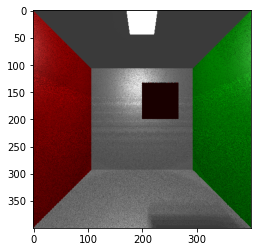

In [17]:
plt.imshow(image)

In [ ]:
# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
image = render(scene, objects)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

In [ ]:
plt.imshow(image)

In [ ]:
illumination = np.zeros((3), dtype=np.float64)
illumination/5

In [ ]:
objects = []

wall_mat1 = Material(color=silver, shininess=89.6, reflection=0.5)
back_wall = Plane(point=np.array([0.0, 0.0, -4.0], dtype=np.float64),
                  normal=np.array([0.0, 0.0, 1.0], dtype=np.float64),
                  material=wall_mat1)
objects.append(back_wall)

top_wall = Plane(point=np.array([0.0, 4.0, 0.0], dtype=np.float64),
                 normal=np.array([0.0, -1.0, 0.0], dtype=np.float64),
                 material=wall_mat1)
objects.append(top_wall)

bottom_wall = Plane(point=np.array([0.0, -4.0, 0.0], dtype=np.float64),
                    normal=np.array([0.0, 1.0, 0.0], dtype=np.float64),
                    material=wall_mat1)
objects.append(bottom_wall)

wall_mat2 = Material(color=maroon, shininess=100, reflection=0.5)
left_wall = Plane(point=np.array([-4.0, 0.0, 0.0], dtype=np.float64),
                  normal=np.array([1.0, 0.0, 0.0], dtype=np.float64),
                  material=wall_mat2)
objects.append(left_wall)

wall_mat3 = Material(color=green, shininess=100, reflection=0.5)
right_wall = Plane(point=np.array([4.0, 0.0, 0.0], dtype=np.float64),
                   normal=np.array([-1.0, 0.0, 0.0], dtype=np.float64),
                   material=wall_mat3)
objects.append(right_wall)

objects

In [ ]:
plt.imshow(image)

In [ ]:
objects = []

wall_mat1 = Material(color=silver, shininess=89.6, reflection=0.5)

back_wall_1 = Triangle(vertex_1=np.array([-4.0, 4.0, -4.0]),
                       vertex_2=np.array([-4.0, -4.0, -4.0]),
                       vertex_3=np.array([4.0, -4.0, -4.0]),
                       material=wall_mat1)

objects.append(back_wall_1)

back_wall_2 = Triangle(vertex_1=np.array([-4.0, 4.0, -4.0]),
                       vertex_2=np.array([4.0, -4.0, -4.0]),
                       vertex_3=np.array([4.0, 4.0, -4.0]),
                       material=wall_mat1)

objects.append(back_wall_2)

top_wall_1 = Triangle(vertex_1=np.array([-4.0, 4.0, -4.0]),
                      vertex_2=np.array([4.0, 4.0, 4.0]),
                      vertex_3=np.array([-4.0, 4.0, 4.0]),
                      material=wall_mat1)

objects.append(top_wall_1)

top_wall_2 = Triangle(vertex_1=np.array([4.0, 4.0, 4.0]),
                      vertex_2=np.array([-4.0, 4.0, -4.0]),
                      vertex_3=np.array([4.0, 4.0, -4.0]),
                      material=wall_mat1)

objects.append(top_wall_2)

bottom_wall_1 = Triangle(vertex_1=np.array([-4.0, -4.0, -4.0]),
                         vertex_2=np.array([-4.0, -4.0, 4.0]),
                         vertex_3=np.array([4.0, -4.0, 4.0]),
                         material=wall_mat1)

objects.append(bottom_wall_1)

bottom_wall_2 = Triangle(vertex_1=np.array([-4.0, -4.0, -4.0]),
                         vertex_2=np.array([4.0, -4.0, 4.0]),
                         vertex_3=np.array([4.0, -4.0, -4.0]),
                         material=wall_mat1)

objects.append(bottom_wall_2)

wall_mat2 = Material(color=maroon, shininess=100, reflection=0.5)

left_wall_1 = Triangle(vertex_1=np.array([-4.0, 4.0, -4.0]),
                       vertex_2=np.array([-4.0, 4.0, 4.0]),
                       vertex_3=np.array([-4.0, -4.0, -4.0]),
                       material=wall_mat2)

objects.append(left_wall_1)

left_wall_2 = Triangle(vertex_1=np.array([-4.0, -4.0, -4.0]),
                       vertex_2=np.array([-4.0, 4.0, 4.0]),
                       vertex_3=np.array([-4.0, -4.0, 4.0]),
                       material=wall_mat2)

objects.append(left_wall_2)


wall_mat3 = Material(color=green, shininess=100, reflection=0.5)

right_wall_1 = Triangle(vertex_1=np.array([4.0, -4.0, -4.0]),
                        vertex_2=np.array([4.0, -4.0, 4.0]),
                        vertex_3=np.array([4.0, 4.0, 4.0]),
                        material=wall_mat3)

objects.append(right_wall_1)

right_wall_2 = Triangle(vertex_1=np.array([4.0, 4.0, -4.0]),
                        vertex_2=np.array([4.0, -4.0, -4.0]),
                        vertex_3=np.array([4.0, 4.0, 4.0]),
                        material=wall_mat3)

objects.append(right_wall_2)

objects

In [ ]:
dim = 1
vertex_1=np.array([-dim, dim, -dim], dtype=np.float64)
vertex_2=np.array([dim, -dim, -dim], dtype=np.float64)
vertex_3=np.array([-dim, -dim, -dim], dtype=np.float64)

(vertex_1[0]+vertex_2[0]+vertex_3[0])/3